# AudioEyes
The goal of this project is to help the vision impaired continue to be self sufficient and read through optical character recognition, text to speech, and NEAR blockchain technology.

I aim to provide an interface which may be connected to a raspberry pi and camera or other hardware. This interface will help users position documents under the camera with voice feedback, help users read with OCR and google text to speech, and help users read through tip motivated manual transcription.

To handle these tips, visually impaired users will have an option to send the transcriber a tip through a smart contract. The transcriber will only receive a set percent of the tip, but transcribers will receive a custom token for every job they do. This token balance will be used to give more active users bonuses when they do jobs.

---

## First, we import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
from tqdm import tqdm
import PIL
from glob import glob
import IPython
import os

# Import AudioEyes
import ImageInterface
import Reader
import requests

---

## Next we import test data

In [2]:
# Make a list of calibration images
calibration_images = [cv2.imread(path) for path in tqdm(glob('../calibration_photos/calibration*.jpg'),
                                                        desc='Calibration Imgs')]
# Make a list of paper test photos
test_docs = [cv2.imread(path) for path in tqdm(glob('../test_photos/*.png'), desc='Test Docs/Images')]

Test Docs/Images: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


## We then initialize ImageInterface and Reader objects

In [3]:
interface = ImageInterface.ImageInterface()
reader = Reader.Reader()

## We then test various functionality for ImageInterface
---

#### Calibration

In [4]:
interface.calibrate(calibration_images)

'Successful Calibration!'

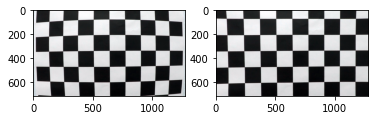

In [5]:
img = cv2.imread('../calibration_photos/calibration1.jpg')
undist_test = interface.undistort(img)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(undist_test)
plt.show()

---

#### Corner Finding

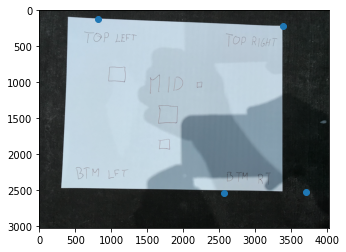

In [6]:
fit_doc = cv2.imread('../test_photos/correct.png')
corners = interface.find_corners(fit_doc)

x = [pos[0][0] for pos in corners]
y = [pos[0][1] for pos in corners]

plt.imshow(fit_doc)
plt.scatter(x,y)

As, even with a wide range of hyperparameters, corner detection proves to be unreliable in non-ideal conditions, I decided to implement the other functions without corner detection. Unreliability could potentially be addressed with custom filtering of which corners count, through gaussian blurring, and through creating a setup with optimal lighting conditions. However, as it is possible to reach the same functionality without using corner finding, for now I do notf consider these improvements worthwhile.

---

#### Getting image alignment instructions

Move object up


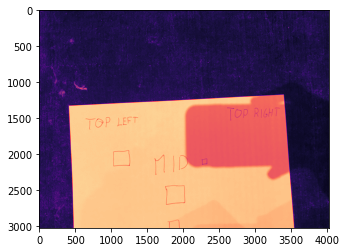

In [7]:
interface = ImageInterface.ImageInterface()

img = cv2.imread('../test_photos/bottom.png')
advice,v,h,grey = interface.get_alignment(img)
print(advice)
plt.imshow(grey)
plt.set_cmap('magma')

Here we get a graph of what my script sees on the vertical axis

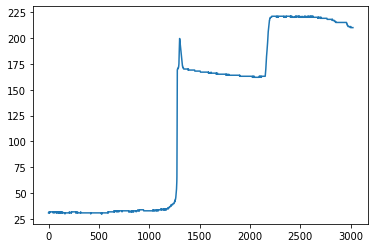

In [8]:
plt.plot(v)

Here we get a graph of what my script sees on the horizontal axis

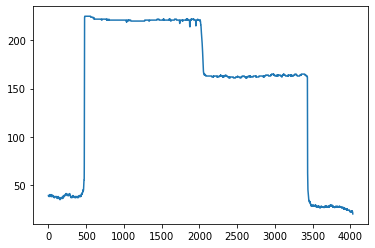

In [9]:
plt.plot(h)

We next run on all images in our test dataset

100%|██████████| 9/9 [00:03<00:00,  2.37it/s]


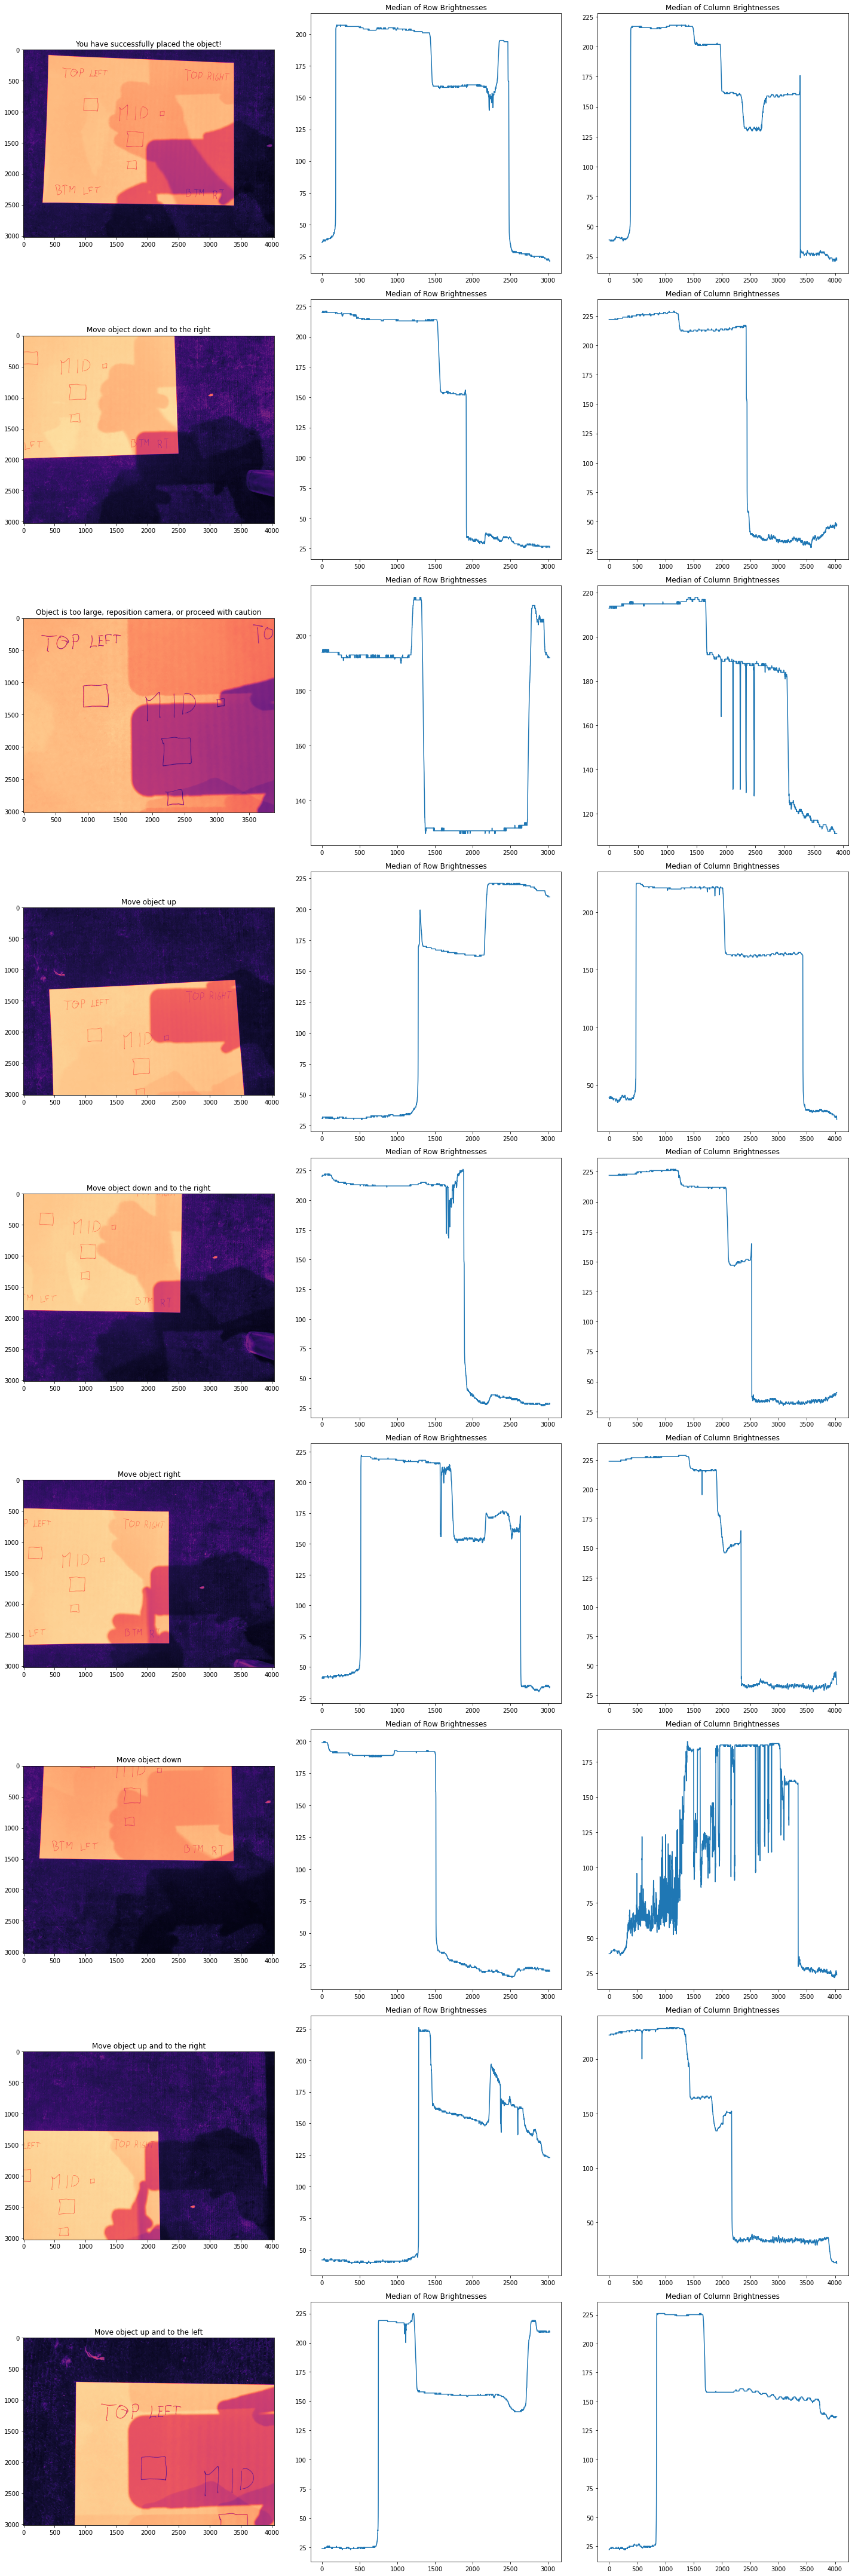

In [10]:
length = len(test_docs)
fig, ax = plt.subplots(length,3,figsize=(20,60))

i = 0
for image in tqdm(test_docs):
    advice,v,h,grey = interface.get_alignment(image)
    ax[i][0].imshow(grey)
    ax[i][0].title.set_text(advice)
    ax[i][1].plot(v)
    ax[i][1].title.set_text('Median of Row Brightnesses')
    ax[i][2].plot(h)
    ax[i][2].title.set_text('Median of Column Brightnesses')
    i+=1

fig.tight_layout()
plt.show()

From this we can see that while the positioning advice functions fairly accurately, shadows have the potential to create troughs in our graphs. While, in these test images, such lows occured outside of the marigin that we test, shadows may create problems in the future. To address this, the hardware setup must include lighting to mitigate shadows. Additionally, a dark surface to place the documents is very necessary.

---

## We then test Text to Speech functionality with and without autocorrect

#### Test actual reading functionality

In [11]:
easy, peasy = interface.get_text(cv2.imread('../OCR_tests/easy_text.png'))
print("Results for Easy Test Case (" + str(peasy) + "% Spelled Correct): " + str(easy))

mod, pmod = interface.get_text(cv2.imread('../OCR_tests/moderate_test.png'))
print("Results for Moderate Test Case (" + str(pmod) + "% Spelled Correct): " + str(mod))

hard, phard = interface.get_text(cv2.imread('../OCR_tests/hard_test.png'))
print("Results for Hard Test Case (" + str(phard) + "% Spelled Correct): " + str(hard))

flash, pflash = interface.get_text(cv2.imread('../OCR_tests/hard_test_flash.png'))
print("Results for Hard Test Case with Flash (" + str(pflash) + "% Spelled Correct): " + str(flash))

Results for Easy Test Case (50.0% Spelled Correct): ['EZ TEST']
Results for Moderate Test Case (78.94736842105263% Spelled Correct): ['  ', 'ceubateinebetdbemsns anenen ten ieaeete ee', 'Test image', 'Sco eit rid 5 dat', '= — ais a a oy:', 'Hello world', 'Gitcoin']
Results for Hard Test Case (100.0% Spelled Correct): ['—', 'te', 'O', 'S', '2', '®', 'ae']
Results for Hard Test Case with Flash (87.5% Spelled Correct): ['Test image', 'Hello world', 'Gitcoin', 'TSS oy ink']


As you can see, the tesseract OCR performs well on printed text, but not well on handwriting. Additionally, the OCR only performs well with adaquate lighting, likely due to the mitigation of noise that comes with properly exposing photos. Therefore, when builing a hardware setup to interface with this code, it is of utmost importance to include proper lighting

---

#### We next test voice functionality

In [12]:
with open('../audio_out/item.mp3', 'wb') as out:
    # Write the response to the output file.
    out.write(reader.read_item('Item test with google text to speech').audio_content)
    print('Audio content written to file "item.mp3"')
    IPython.display.display(IPython.display.Audio(url='../audio_out/item.mp3'))

test_list = reader.read_list(['testing with word separation', 'testing google text to speech'])
i = 1;
for audio in test_list:
    with open('../audio_out/list_item_' + str(i) + '.mp3', 'wb') as out:
        # Write the response to the output file.
        out.write(audio.audio_content)
        print('Audio content written to file "list_item_' + str(i) + '.mp3"')
        IPython.display.display(IPython.display.Audio(url='../audio_out/list_item_' + str(i) + '.mp3'))
    i += 1

Audio content written to file "item.mp3"


Audio content written to file "list_item_1.mp3"


Audio content written to file "list_item_2.mp3"


#### We then test voice generation with autocorrect enabled

In [13]:
with open('../audio_out/item_autocorrect.mp3', 'wb') as out:
    # Write the response to the output file.
    out.write(reader.read_item('Itim tist weth google teext to spech', autocorrect = True).audio_content)
    print('Audio content written to file "item_autocorrect.mp3"')
    IPython.display.display(IPython.display.Audio(url='../audio_out/item_autocorrect.mp3'))

test_list = reader.read_list(['trsting with qord seperation', 'tusting google teext to spech'], autocorrect = True)
i = 1;
for audio in test_list:
    with open('../audio_out/list_item_' + str(i) + '_autocorrect.mp3', 'wb') as out:
        # Write the response to the output file.
        out.write(audio.audio_content)
        print('Audio content written to file "list_item_' + str(i) + '_autocorrect.mp3"')
        IPython.display.display(IPython.display.Audio(url='../audio_out/list_item_' + str(i) + '_autocorrect.mp3'))
    i += 1

Audio content written to file "item_autocorrect.mp3"


Audio content written to file "list_item_1_autocorrect.mp3"


Audio content written to file "list_item_2_autocorrect.mp3"


---

## We then test NEAR Integration

#### First we run commands to initialize the command line interface

In [14]:
account = 'cyd2.testnet'; # replace with your own account if you are running this notebook
smart_contract = 'thecydonian.testnet'

os.system('npm i -g near-shell')
out = os.popen('near login')
print(out.read())

Using options: {
  networkId: 'default',
  nodeUrl: 'https://rpc.testnet.near.org',
  contractName: undefined,
  walletUrl: 'https://wallet.testnet.near.org',
  helperUrl: 'https://helper.testnet.near.org',
  initialBalance: null
}

Please authorize NEAR Shell on at least one of your accounts.

If your browser doesn't automatically open, please visit this URL
https://wallet.testnet.near.org/login/?title=NEAR+Shell&public_key=ed25519%3ABzH16M9HhB4a4monHLMSjiJE5GTrAuJdKNvWDKZ5uRyu&success_url=http%3A%2F%2F127.0.0.1%3A5000
Please authorize at least one account at the URL above.

Which account did you authorize for use with NEAR Shell?
Enter it here (if not redirected automatically):
Logged in as [ cyd2.testnet ] with public key [ ed25519:BzH16M... ] successfully




---
#### We then test adding a request

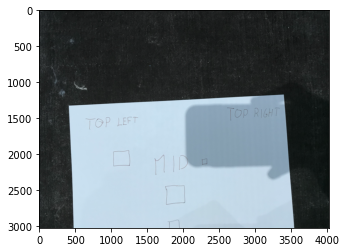

In [15]:
plt.imshow(img)

In [20]:
out = interface.send_to_workers(img, smart_contract, account);
print(out[0].read())
print(out[1])
img_hash = out[1];

<_io.BufferedReader name='../img_cache/img.png'>
Using options: {
  accountId: 'cyd2.testnet',
  networkId: 'default',
  nodeUrl: 'https://rpc.testnet.near.org',
  contractName: 'thecydonian.testnet',
  walletUrl: 'https://wallet.testnet.near.org',
  helperUrl: 'https://helper.testnet.near.org',
  gas: '100000000000000',
  amount: '0',
  methodName: 'req_transcription',
  args: '{"img": "fJJ6MpslukLK+ENn2mEHvZHgISaAKpGLQHKriqaeH90="}',
  initialBalance: null
}
Scheduling a call: thecydonian.testnet.req_transcription({"img": "fJJ6MpslukLK+ENn2mEHvZHgISaAKpGLQHKriqaeH90="})
''

fJJ6MpslukLK+ENn2mEHvZHgISaAKpGLQHKriqaeH90=


---
#### Pulls Transcription from NEAR

In [17]:
out = interface.get_solved(img_hash, smart_contract, account)
trans = out[0]
t_account = out[1]
print('transcription:\n{}\n'.format(trans))
print('transcriber account: {}'.format(t_account))

transcription:
TOP LEFT
TOP RIGHT
MID

transcriber account: cyd2.testnet


---
#### Tips user responsible

In [19]:
out = interface.tip(t_account, '2', smart_contract, account)
print(out.read())

Using options: {
  accountId: 'cyd2.testnet',
  amount: '2',
  networkId: 'default',
  nodeUrl: 'https://rpc.testnet.near.org',
  contractName: 'thecydonian.testnet',
  walletUrl: 'https://wallet.testnet.near.org',
  helperUrl: 'https://helper.testnet.near.org',
  gas: '100000000000000',
  methodName: 'send_tip',
  args: '{"account_id": "cyd2.testnet"}',
  initialBalance: null
}
Scheduling a call: thecydonian.testnet.send_tip({"account_id": "cyd2.testnet"}) with attached 2 NEAR
''

